In [1]:
from contextlib import suppress
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import os
import warnings


from keras import applications
from keras import optimizers
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14762991602922486785
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6784148917304290908
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 32069153588
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 14334109296571545076
physical_device_desc: "device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:5c:00.0, compute capability: 7.0"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 32069153588
locality {
  bus_id: 2
  numa_node: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 1605141258486478768
physical_device_desc: "device: 1, name: Tesla V100-PCIE-32GB, pci bus id: 0000:d8:00.0, compute capability: 7.0"
, name: "/device:XLA_GPU:0"
device_type: "XLA_

In [3]:
np.random.seed(8)

In [4]:
class_names = os.listdir('/panfs/roc/groups/14/kumarbio/rai00016/Capstone/Data/NWPURESISC_19/Train/')
target_dirs = {target: '/panfs/roc/groups/14/kumarbio/rai00016/Capstone/Data/NWPURESISC_19/' + target for target in ['Train', 'Validation', 'Test']}

In [5]:
print(class_names)
print(target_dirs)

['airplane', 'baseball_diamond', 'beach', 'chaparral', 'dense_residential', 'forest', 'freeway', 'golf_course', 'harbor', 'intersection', 'medium_residential', 'mobile_home_park', 'overpass', 'parking_lot', 'river', 'runway', 'sparse_residential', 'storage_tank', 'tennis_court']
{'Train': '/panfs/roc/groups/14/kumarbio/rai00016/Capstone/Data/NWPURESISC_19/Train', 'Validation': '/panfs/roc/groups/14/kumarbio/rai00016/Capstone/Data/NWPURESISC_19/Validation', 'Test': '/panfs/roc/groups/14/kumarbio/rai00016/Capstone/Data/NWPURESISC_19/Test'}


In [6]:
def get_bottleneck_features( dataset, batch_size=64):
    print(dataset)
    image_data_gen = ImageDataGenerator(rescale=1/255.0)
    image_generator = image_data_gen.flow_from_directory(target_dirs[dataset],
                                                        batch_size=batch_size,
                                                       target_size=(299, 299),
                                                        shuffle=False)
    image_count = 0
    X_batches, Y_batches = [], []
    for X, Y in image_generator:
        X_batches.append(X)
        Y_batches.append(Y)
        image_count += X.shape[0]
        if image_count >= image_generator.n:
            break
    X = np.concatenate(X_batches)
    Y = np.concatenate(Y_batches)
    return X, Y

In [7]:
num_classes = len(class_names)
X, Y = dict(), dict()
for dataset in ['Train', 'Validation', 'Test']:
    # Extract bottleneck features from pretrained model, predicting from "dataset" directory
    X[dataset], Y[dataset] = get_bottleneck_features( dataset)

Train
Found 10640 images belonging to 19 classes.
Validation
Found 1330 images belonging to 19 classes.
Test
Found 1330 images belonging to 19 classes.


In [8]:
model = applications.InceptionResNetV2(include_top=True, weights=None, classes=num_classes)

In [9]:
model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
________________________________________________________________________________

In [10]:
def build_fully_connected(input_shape, num_classes):
    """
    Create a fully-connected model to train or test on UC Merced dataset.
    """
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [11]:
X['Train'].shape[1:]

(299, 299, 3)

In [12]:
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
epochs = 300
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)
adam = optimizers.Adam(lr=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:

model_fit_history = model.fit(X['Train'], Y['Train'], batch_size=64, epochs=100,
                              verbose=2, validation_data=(X['Validation'], Y['Validation']))

Train on 10640 samples, validate on 1330 samples
Epoch 1/100
 - 272s - loss: 1.1865 - accuracy: 0.6131 - val_loss: 6.5294 - val_accuracy: 0.0534
Epoch 2/100
 - 179s - loss: 0.6999 - accuracy: 0.7752 - val_loss: 5.8390 - val_accuracy: 0.1105
Epoch 3/100
 - 178s - loss: 0.5108 - accuracy: 0.8344 - val_loss: 3.1366 - val_accuracy: 0.2992
Epoch 4/100
 - 177s - loss: 0.3719 - accuracy: 0.8789 - val_loss: 0.7878 - val_accuracy: 0.7632
Epoch 5/100
 - 177s - loss: 0.3063 - accuracy: 0.8995 - val_loss: 0.6523 - val_accuracy: 0.7789
Epoch 6/100
 - 177s - loss: 0.2227 - accuracy: 0.9282 - val_loss: 0.6698 - val_accuracy: 0.8015
Epoch 7/100
 - 177s - loss: 0.1892 - accuracy: 0.9384 - val_loss: 0.8179 - val_accuracy: 0.7624
Epoch 8/100
 - 177s - loss: 0.1423 - accuracy: 0.9547 - val_loss: 0.9304 - val_accuracy: 0.7579
Epoch 9/100
 - 178s - loss: 0.1218 - accuracy: 0.9609 - val_loss: 0.5229 - val_accuracy: 0.8677
Epoch 10/100
 - 178s - loss: 0.1086 - accuracy: 0.9658 - val_loss: 0.3602 - val_accurac

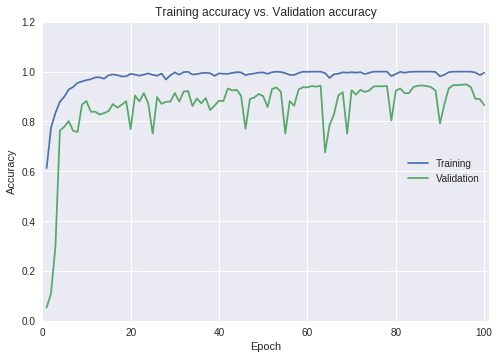

In [14]:
matplotlib.style.use('seaborn')
epochs = len(model_fit_history.history['accuracy'])
plt.axis([0, epochs+1, 0, 1.2])
x = np.arange(1, epochs+1)
plt.plot(x, model_fit_history.history['accuracy'])
plt.plot(x, model_fit_history.history['val_accuracy'])
plt.title('Training accuracy vs. Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()

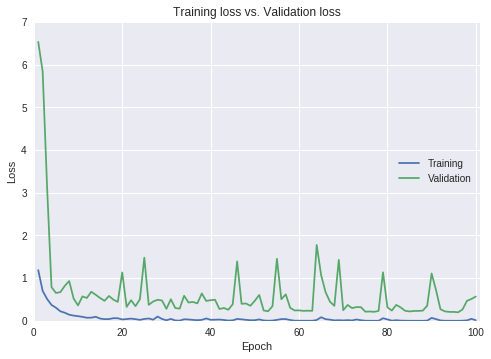

In [15]:
matplotlib.style.use('seaborn')
epochs = len(model_fit_history.history['loss'])
max_loss = max(max(model_fit_history.history['loss']), max(model_fit_history.history['val_loss']))
plt.axis([0, epochs+1, 0, round(max_loss * 2.0) / 2 + 0.5])
x = np.arange(1, epochs+1)
plt.plot(x, model_fit_history.history['loss'])
plt.plot(x, model_fit_history.history['val_loss'])
plt.title('Training loss vs. Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()


In [16]:
y_pred = model.predict(np.array(X['Test']))

In [17]:
y_pred

array([[9.9994433e-01, 4.7236739e-08, 5.5223791e-07, ..., 8.3292366e-11,
        1.4534699e-07, 5.8902678e-08],
       [6.4937639e-01, 1.0644242e-04, 1.3421671e-04, ..., 4.5630787e-04,
        2.8581623e-02, 7.3448733e-05],
       [9.9882358e-01, 1.8167493e-05, 4.6435784e-04, ..., 4.3158447e-08,
        1.0379041e-04, 4.5032393e-05],
       ...,
       [8.3018213e-21, 8.0506849e-17, 2.3116340e-24, ..., 6.4595661e-23,
        7.4433053e-18, 1.0000000e+00],
       [2.3661293e-08, 5.5842202e-06, 3.8325059e-08, ..., 5.9185819e-08,
        2.7117574e-07, 9.9998474e-01],
       [6.0771044e-13, 3.5369957e-10, 2.0168579e-17, ..., 6.4396921e-10,
        3.1126705e-11, 1.0000000e+00]], dtype=float32)

In [18]:
y_pred_final = y_pred.argmax(axis = -1)

y_test = Y['Test']
ct = []
cp = []
acc = 0 
for i in range(y_test.shape[0]):
    class_true = np.where(y_test[i] == np.amax(y_test[i]))[0][0]
    ct.append(class_true)
    class_pred = y_pred_final[i]
    cp.append(class_pred)
    if class_true == class_pred:
        acc = acc + 1

accuracy = acc / y_test.shape[0]

In [19]:

print(accuracy_score(ct, cp))
print(classification_report(ct, cp))

0.8834586466165414
              precision    recall  f1-score   support

           0       1.00      0.76      0.86        70
           1       0.96      0.99      0.97        70
           2       0.86      0.94      0.90        70
           3       0.97      1.00      0.99        70
           4       0.87      0.86      0.86        70
           5       0.93      0.96      0.94        70
           6       0.81      0.91      0.86        70
           7       0.77      1.00      0.87        70
           8       0.95      0.90      0.93        70
           9       0.93      0.80      0.86        70
          10       0.88      0.60      0.71        70
          11       0.71      0.97      0.82        70
          12       0.90      0.91      0.91        70
          13       1.00      0.73      0.84        70
          14       0.86      0.96      0.91        70
          15       0.92      0.86      0.89        70
          16       0.98      0.76      0.85        70
        